In [ ]:
import pandas as pd
#Carga de datos
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
    name=fn
df = pd.read_csv(name, sep=";", encoding='utf-8')

Saving Anexo ET_demo_round_traces_2022 (2).csv to Anexo ET_demo_round_traces_2022 (2).csv


/tmp/ipython-input-6-2125804881.py:7: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(name, sep=";", encoding='utf-8')


In [ ]:
df['headshot_ratio'] = df['RoundHeadshots'] / (df['RoundKills'] + 1e-5)
df['flank_kill_ratio'] = df['RoundFlankKills'] / (df['RoundKills'] + 1e-5)


In [ ]:
# Limpiar 'RoundWinner'
df = df[df['RoundWinner'].isin(['True', 'False'])]
df['RoundWinner'] = df['RoundWinner'].map({'True': 1, 'False': 0})


/tmp/ipython-input-8-2457127219.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RoundWinner'] = df['RoundWinner'].map({'True': 1, 'False': 0})


In [ ]:
# Revisar columnas tipo object
print(df.select_dtypes(include='object').columns)

# Eliminar columnas irrelevantes o que no aportan (ajústalo según tus necesidades)
columnas_a_remover = [
    'MatchId', 'PlayerId', 'Map', 'Team',
    'TimeAlive', 'FirstKillTime', 'TravelledDistance',
    'AbnormalMatch'
]

df = df.drop(columns=[col for col in columnas_a_remover if col in df.columns])


Index(['Map', 'Team', 'MatchWinner', 'TimeAlive', 'TravelledDistance',
       'FirstKillTime'],
      dtype='object')


In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop(['RoundWinner', 'MatchWinner'], axis=1)
y = df['RoundWinner']

# División estratificada
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
for col in df.columns:
    if df[col].nunique() == 1:
        df.drop(columns=col, inplace=True)


In [ ]:
# Eliminar columnas con +50% NaN
df = df.loc[:, df.isnull().mean() < 0.5]

# Eliminar filas con NaN restantes
df = df.dropna()


In [ ]:
# Verificar tipo de columnas finales
print(df.dtypes)


Unnamed: 0                       int64
InternalTeamId                   int64
RoundId                          int64
RoundWinner                      int64
MatchWinner                     object
Survived                          bool
RLethalGrenadesThrown            int64
RNonLethalGrenadesThrown         int64
PrimaryAssaultRifle            float64
PrimarySniperRifle             float64
PrimaryHeavy                   float64
PrimarySMG                     float64
PrimaryPistol                    int64
RoundKills                       int64
RoundAssists                     int64
RoundHeadshots                   int64
RoundFlankKills                  int64
RoundStartingEquipmentValue      int64
TeamStartingEquipmentValue       int64
MatchKills                       int64
MatchFlankKills                  int64
MatchAssists                     int64
MatchHeadshots                   int64
headshot_ratio                 float64
flank_kill_ratio               float64
dtype: object


In [ ]:
df.to_csv("ET_limpio.csv", index=False)


In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np

cat_cols = X.select_dtypes(include=['object', 'bool']).columns
num_cols = X.select_dtypes(include=np.number).columns

preprocessor = ColumnTransformer([
    ('num', 'passthrough', num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])


In [ ]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline

model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        learning_rate=0.01,
        n_estimators=1000,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ))
])

model.fit(X_train, y_train)

# Predicciones
y_probs = model.predict_proba(X_test)[:, 1]


AUC: 0.8630


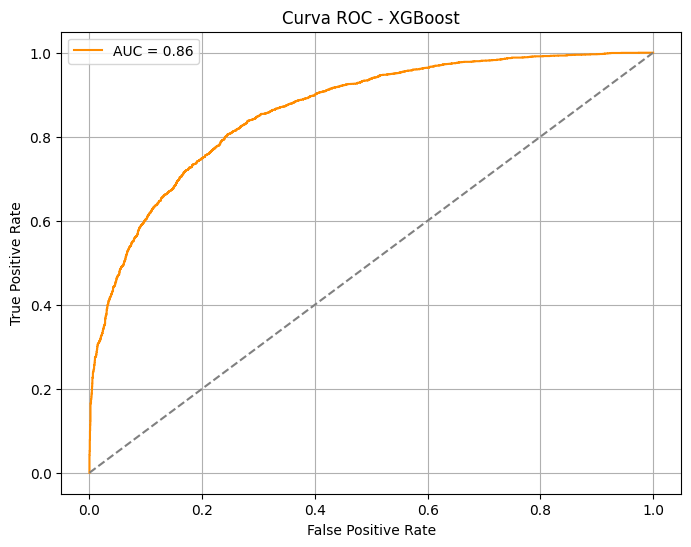

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

auc_score = roc_auc_score(y_test, y_probs)
print(f"AUC: {auc_score:.4f}")

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - XGBoost')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
print(X.columns.tolist())

['Unnamed: 0', 'InternalTeamId', 'RoundId', 'Survived', 'RLethalGrenadesThrown', 'RNonLethalGrenadesThrown', 'PrimaryAssaultRifle', 'PrimarySniperRifle', 'PrimaryHeavy', 'PrimarySMG', 'PrimaryPistol', 'RoundKills', 'RoundAssists', 'RoundHeadshots', 'RoundFlankKills', 'RoundStartingEquipmentValue', 'TeamStartingEquipmentValue', 'MatchKills', 'MatchFlankKills', 'MatchAssists', 'MatchHeadshots', 'headshot_ratio', 'flank_kill_ratio']


In [ ]:
import pickle

# Nombre del archivo para guardar el modelo
filename = 'modelo_xgboost.pkl'

# Guardar el modelo en formato pkl
with open(filename, 'wb') as file:
    pickle.dump(model, file)

print(f"Modelo exportado exitosamente a '{filename}'")

Modelo exportado exitosamente a 'modelo_xgboost.pkl'


In [ ]:
from google.colab import files

files.download('modelo_xgboost.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>